# Get a custom distribution to work, scale and loc included
Brian Larsen

20180519

In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as tt
import numpy as np
import scipy.stats
import tqdm

sns.set(font_scale=1.5)
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Read in data
Data are the geomagnetic index Dst obtained from George Mason Univ (http://mag.gmu.edu/ftp/OMNI/OMNI2/merged/latest/)

Dst: https://www.ngdc.noaa.gov/stp/geomag/dst.html

I changed the CDF into a pandas dataframe (h5 file) with only the Dst variable

In [2]:
dst = pd.read_hdf('Dst_data.h5')
dst.head()

,Dst
1963-01-01 00:30:00,-6.0
1963-01-01 01:30:00,-5.0
1963-01-01 02:30:00,-5.0
1963-01-01 03:30:00,-3.0
1963-01-01 04:30:00,-3.0


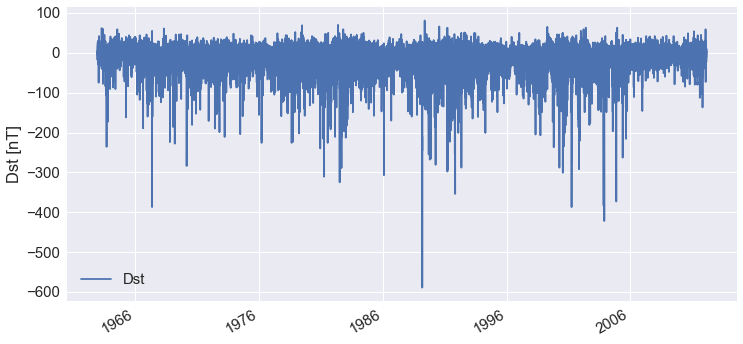

In [3]:
dst = pd.read_hdf('Dst_data.h5')
dst.plot(figsize=(12,6))
plt.ylabel('Dst [nT]');

## Maximum likelihood fit
Use scipy.stats and get a fit to the distribution. At this point no physics in choosing the distribution, it just fit well. 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


scale and loc form scipy: -8.031573809290007 18.887900093929694


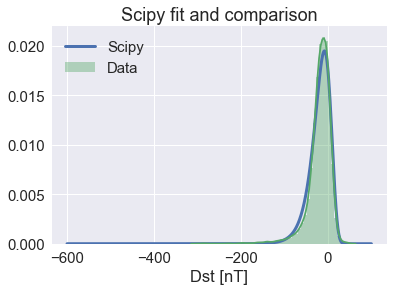

In [4]:

d = scipy.stats.gumbel_l.fit(dst.loc['2000'])
XX = np.linspace(-600, 100, 1000)
plt.plot(XX, scipy.stats.gumbel_l(*d).pdf(XX), label='Scipy', lw=3)

sns.distplot(dst.loc['2000'], label='Data')
plt.xlabel('Dst [nT]')
plt.title('Scipy fit and comparison')
plt.legend();
print('scale and loc form scipy: {} {}'.format(*d))

## Perfrom the fit with pymc3
This will give some more power for the next steps such as fitting an AR model.

In [23]:
def logp(value):
     return value - pm.math.exp(value)

with pm.Model() as model:
    scale = pm.HalfNormal('scale', sd=10, testval=10)
    loc = pm.Uniform('loc', -100, 100, testval=0)
    y = (dst.loc['2000'].values - loc) / scale
    gumbel_l = pm.DensityDist('gumbel_l', logp, testval=0, observed=y)
    trace = pm.sample(2000, )

    

IndexError: too many indices for array

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
scale,153.482274,5.035306,0.072810,144.322294,163.788778,3952.024414,0.999966
loc,-16.836087,1.666397,0.028184,-19.983089,-13.430202,3978.612559,0.999989


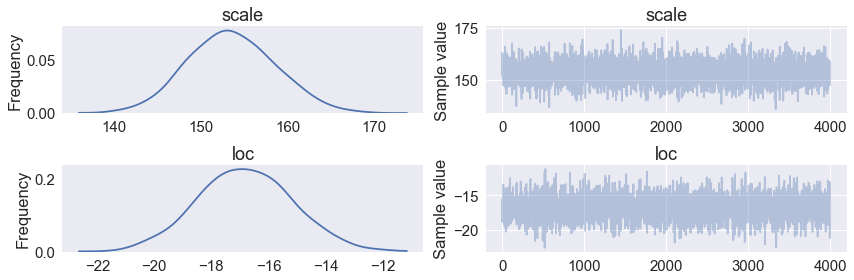

In [10]:
pm.traceplot(trace, combined=True)
pm.summary(trace)

Things do look like they converged but The answers are a heck of a lot different than scipy got. Fit is likely to be poor.

In [7]:
# don't seem to be able to use PPC without defining a random()

#     y = (dst.loc['2000'].values - loc) / scale

ppc = np.asarray([scipy.stats.gumbel_l(scale=trace['scale'][ii], 
                                       loc=trace['loc'][ii]).rvs(size=10)
                  for ii, v in enumerate(np.random.randint(0, len(trace), 1000))])



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


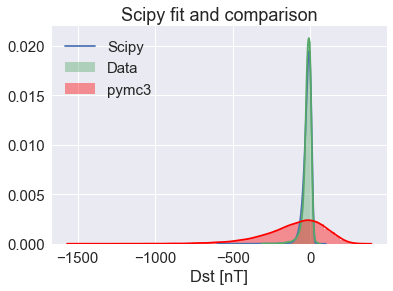

In [8]:
d = scipy.stats.gumbel_l.fit(dst.loc['2000'])
XX = np.linspace(-600, 100, 1000)

plt.plot(XX, scipy.stats.gumbel_l(*d).pdf(XX), label='Scipy')

sns.distplot(dst.loc['2000'], label='Data')

sns.distplot(ppc.flatten(), label='pymc3', color='r')


plt.xlabel('Dst [nT]')
plt.title('Scipy fit and comparison')
plt.legend();


Fit is indeed poor, likely I am doing something wrong...

## Try again with scale "better"


In [24]:
def logp(value):
     return value - pm.math.exp(value)

with pm.Model() as model:
    scale = pm.HalfNormal('scale', sd=10, testval=10)
    loc = pm.Uniform('loc', -100, 100, testval=0)
    y = (dst.loc['2000'].values - loc) / scale
    gumbel_l = pm.DensityDist('gumbel_l', logp, testval=0, observed=y)
    gumbel_fit = pm.Deterministic('gumbel_fit', gumbel_l/scale) 
    trace = pm.sample(2000, )

    

TypeError: For compute_test_value, one input test value does not have the requested type.

The error when converting the test value to that variable type:
Wrong number of dimensions: expected 1, got 2 with shape (8784, 1).